### 1. Import Required Libraries

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

warnings.filterwarnings("ignore")

### 2. Load Dataset

In [2]:
train_data_set = pd.read_csv("../input/train.csv")

### 3. Preview Data and Fill Missing Values

In [3]:
train_data_set.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# Check number of rows and columns.
train_data_set.shape

(891, 12)

In [5]:
# df.describe() gives statistical information of numerical variables in the data.
train_data_set.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
train_data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


###### Column "Age", "Cabin", "Embarked" has missing values

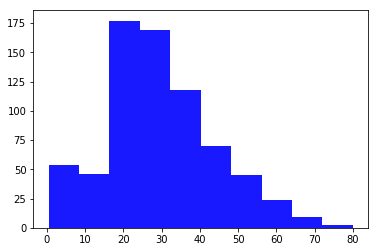

In [7]:
train_data_set["Age"].hist(alpha=0.9, grid=False, color='blue')

###### The age feature is right skewed,will use median to fill the missing values

In [8]:
# Fill Missing Values for Age
train_data_set["Age"].fillna(train_data_set["Age"].median(), inplace=True)

In [9]:
train_data_set["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [10]:
# Fill Missing Values for Embarked
train_data_set["Embarked"].fillna("S", inplace=True)

In [11]:
# Fill Missing Values for Cabin
train_data_set["Cabin"] = train_data_set["Cabin"].apply(lambda x: str(x)[0])
train_data_set.groupby(["Cabin", "Pclass"])["Pclass"].count()

Cabin  Pclass
A      1          15
B      1          47
C      1          59
D      1          29
       2           4
E      1          25
       2           4
       3           3
F      2           8
       3           5
G      3           4
T      1           1
n      1          40
       2         168
       3         479
Name: Pclass, dtype: int64

In [12]:
# Replace NaN with 0, and other Characters with numeric value
train_data_set["Cabin"] = train_data_set["Cabin"].replace("n", 0)
train_data_set["Cabin"] = train_data_set["Cabin"].replace(["A", "B", "C", "D", "E", "T"], 1)
train_data_set["Cabin"] = train_data_set["Cabin"].replace("F", 2)
train_data_set["Cabin"] = train_data_set["Cabin"].replace("G", 3)

### 4. EDA

#### 4.1 Compare total survivors and male female survivors. 

In [13]:
# Get total number of male and females.
total_survivors = train_data_set[train_data_set['Survived'] == 1].count()[1]
total_non_survivors = train_data_set[train_data_set['Survived'] == 0].count()[1]

# Get total number of male and female survivors.
male_survivors = train_data_set['Survived'][train_data_set['Sex'] == 'male'].value_counts()[1]
female_survivors = train_data_set['Survived'][train_data_set['Sex'] == 'female'].value_counts()[1]

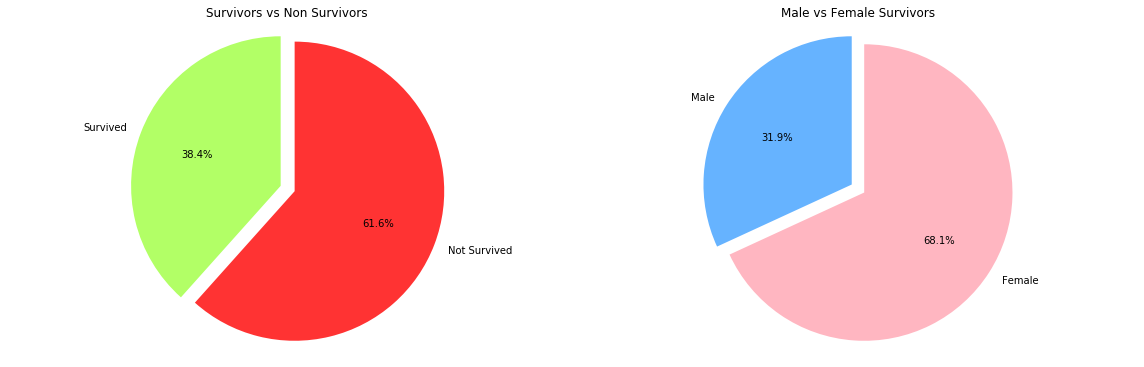

In [14]:
total = [total_survivors, total_non_survivors]
survivors = [male_survivors, female_survivors]


total_colors = ['#B2FF66', '#FF3333'] 
survive_colors = ['#66b3ff', '#FFB6C1']

plt.figure(figsize = (16, 10))
explode = (0.05,0.05)

ax1 = plt.subplot2grid((2,2), (0,0))
plt.pie(total, labels = ["Survived", "Not Survived"], colors = total_colors, explode = explode, autopct = '%1.1f%%', startangle = 90)
plt.title("Survivors vs Non Survivors")
plt.axis('equal')

ax1 = plt.subplot2grid((2,2), (0,1))
plt.pie(survivors, labels = ["Male", "Female"], colors = survive_colors, explode = explode, autopct = '%1.1f%%', startangle = 90)
plt.title("Male vs Female Survivors")
plt.axis('equal')

plt.axis('equal')
plt.tight_layout()
plt.show()

###### Not many survived the accident and Females have high probability of survival than Men.

#### 4.2 Compare Survivors From The Place They Embarked

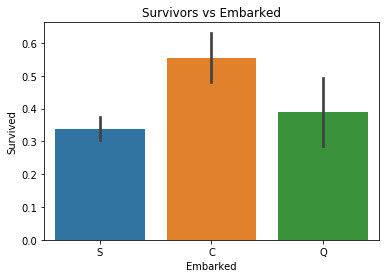

In [15]:
sns.barplot(x="Embarked", y="Survived", data=train_data_set)
plt.title("Survivors vs Embarked")
plt.show()

###### Passengers who embarked from Cherbourg has high probability of survival.

#### 4.3 Compare Survivors Based On Pclass

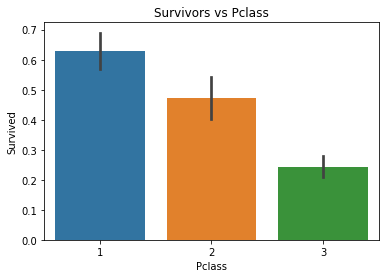

In [16]:
sns.barplot(x="Pclass", y="Survived", data=train_data_set)
plt.title("Survivors vs Pclass")
plt.show()

#### Passengers from 1st class has more survivals, maybe because of high fare.

#### 4.4 Check SibSp Count

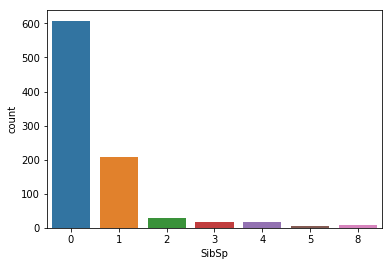

In [17]:
sns.countplot(x="SibSp", data=train_data_set)
plt.show()

###### Most of the passengers were travelling alone.

#### 4.5 Compare Survivors and Age

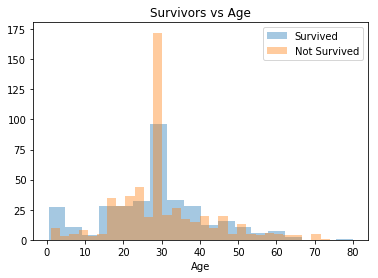

In [18]:
sns.distplot(train_data_set[train_data_set['Survived'] == 1].Age.dropna(), bins=18, label = "Survived", kde =False)
sns.distplot(train_data_set[train_data_set["Survived"] == 0]["Age"].dropna(), bins = 30, label="Not Survived", kde=False)
plt.title("Survivors vs Age")
plt.legend()
plt.show()

### 5. Feature Engineering

In [19]:
# copy the data frame for future use.
copy_train_data = train_data_set.copy()

In [20]:
# Create a new feature "FamilySize", by combining "SibSP" and "Parch"
# Plus 1 is added as the passenger is also considered part of the family.
train_data_set["FamilySize"] = train_data_set["SibSp"] + train_data_set["Parch"] + 1

In [21]:
# Convert Categorical Data to Numeric
train_data_set["Sex"] = train_data_set["Sex"].map({"male": 1, "female": 0}).astype(int)
# Convert to numeric data
train_data_set["Embarked"] = train_data_set["Embarked"].map({"S": 1, "C": 2, "Q": 3})

In [22]:
# Drop unwanted columns
train_data_set.drop(["PassengerId", "Name", "SibSp", "Parch", "Ticket"], axis=1, inplace=True)

In [23]:
train_data_set.head()

,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,FamilySize
0,0,3,1,22.0,7.2500,0,1,2
1,1,1,0,38.0,71.2833,1,2,2
2,1,3,0,26.0,7.9250,0,1,1
3,1,1,0,35.0,53.1000,1,1,2
4,0,3,1,35.0,8.0500,0,1,1


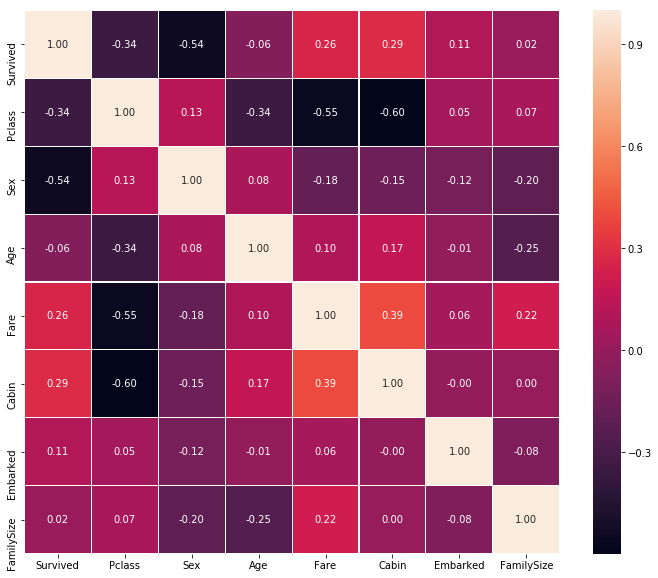

In [24]:
# Find the correlation between the variables.
plt.figure(figsize=(12,10))
sns.heatmap(train_data_set.corr(), linewidths=0.05, fmt= ".2f", annot=True)
plt.show()

###### Fare, Cabin, Embarked, FamilySize has positive correlation with Survived

### 6. Model Fitting

In [25]:
X = train_data_set.drop("Survived", axis=1)
Y = train_data_set["Survived"]

In [26]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [27]:
standard_scaler = StandardScaler()

x_train = standard_scaler.fit_transform(x_train)
x_test = standard_scaler.transform(x_test)

##### Random Forest Classifier

In [28]:
# Random Forest Classifer Model
rf_model = RandomForestClassifier(criterion="entropy", max_depth=10, random_state=42)
rf_model.fit(x_train, y_train)
rf_pred = rf_model.predict(x_test)

In [29]:
rf_accuracy = accuracy_score(rf_pred, y_test)
print("Random Forest Accuracy: ", rf_accuracy)

Random Forest Accuracy:  0.8324022346368715


In [30]:
print(classification_report(rf_pred, y_test))

              precision    recall  f1-score   support

           0       0.89      0.84      0.86       111
           1       0.76      0.82      0.79        68

   micro avg       0.83      0.83      0.83       179
   macro avg       0.82      0.83      0.82       179
weighted avg       0.84      0.83      0.83       179



In [31]:
rf_cm = confusion_matrix(rf_pred, y_test)

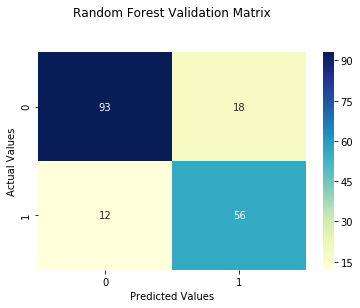

In [32]:
sns.heatmap(rf_cm, annot = True, fmt = ".0f", cmap = "YlGnBu")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.title("Random Forest Validation Matrix\n\n")
plt.show()

##### Logistic Regression

In [33]:
# Logistic Regression Model
lr_model = LogisticRegression()
lr_model.fit(x_train, y_train)
lr_pred = lr_model.predict(x_test)

In [34]:
lr_accuracy = accuracy_score(lr_pred, y_test)
print("Logistic Regression Accuracy: ", lr_accuracy)

Logistic Regression Accuracy:  0.8156424581005587


In [35]:
print(classification_report(lr_pred, y_test))

              precision    recall  f1-score   support

           0       0.87      0.83      0.85       110
           1       0.74      0.80      0.77        69

   micro avg       0.82      0.82      0.82       179
   macro avg       0.80      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179



In [36]:
lr_cm = confusion_matrix(lr_pred, y_test)

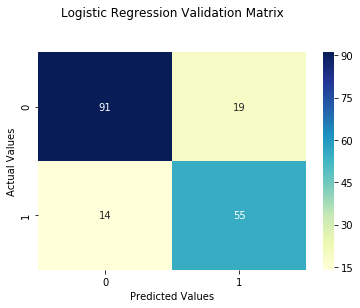

In [37]:
sns.heatmap(lr_cm, annot = True, fmt = ".0f", cmap = "YlGnBu")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.title("Logistic Regression Validation Matrix\n\n")
plt.show()

##### Decision Tree Classifier

In [38]:
# Decision Tree Classifier Model
dt_model = DecisionTreeClassifier(criterion="entropy", random_state=42)
dt_model.fit(x_train, y_train)
dt_pred = dt_model.predict(x_test)

In [39]:
dt_accuracy = accuracy_score(dt_pred, y_test)
print("Decision Tree Accuracy: ", dt_accuracy)

Decision Tree Accuracy:  0.8044692737430168


In [40]:
print(classification_report(dt_pred, y_test))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83       100
           1       0.80      0.75      0.77        79

   micro avg       0.80      0.80      0.80       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.80      0.80      0.80       179



In [41]:
dt_cm = confusion_matrix(dt_pred, y_test)

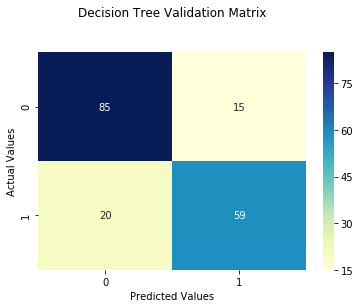

In [42]:
sns.heatmap(dt_cm, annot = True, fmt = ".0f", cmap = "YlGnBu")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.title("Decision Tree Validation Matrix\n\n")
plt.show()

##### Support Vector Machine

In [43]:
# Support Vector Machine Model
svm_model = SVC()
svm_model.fit(x_train, y_train)
svm_pred = svm_model.predict(x_test)

In [44]:
svm_accuracy = accuracy_score(svm_pred, y_test)
print("SVM Accuracy: ", svm_accuracy)

SVM Accuracy:  0.8100558659217877


In [45]:
print(classification_report(svm_pred, y_test))

              precision    recall  f1-score   support

           0       0.90      0.80      0.85       119
           1       0.68      0.83      0.75        60

   micro avg       0.81      0.81      0.81       179
   macro avg       0.79      0.82      0.80       179
weighted avg       0.83      0.81      0.81       179



In [46]:
svm_cm = confusion_matrix(svm_pred, y_test)

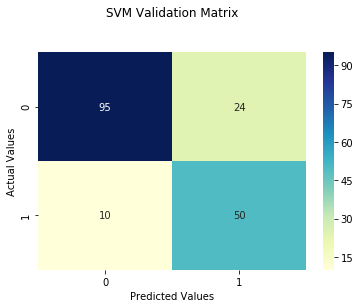

In [47]:
sns.heatmap(svm_cm, annot = True, fmt = ".0f", cmap = "YlGnBu")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.title("SVM Validation Matrix\n\n")
plt.show()

###### Plot Accuracy of Models

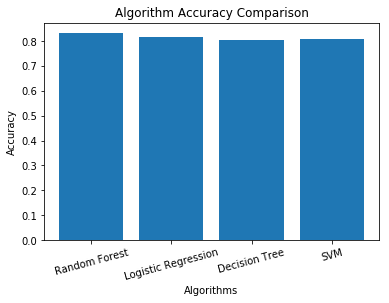

In [48]:
x = ["Random Forest", "Logistic Regression", "Decision Tree", "SVM"]
y = [rf_accuracy, lr_accuracy, dt_accuracy, svm_accuracy]
plt.bar(x=x, height=y)
plt.title("Algorithm Accuracy Comparison")
plt.xticks(rotation=15)
plt.xlabel("Algorithms")
plt.ylabel("Accuracy")
plt.show()

###### Plot Feature Importance of RandomForestClassifier

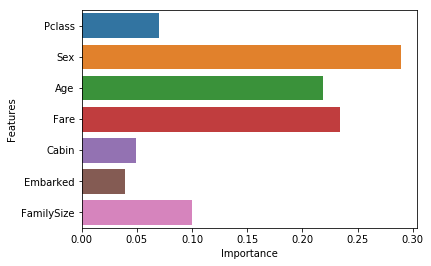

In [49]:
copy_data_set = train_data_set.copy()
copy_data_set.drop("Survived", axis=1, inplace=True)
plot_df = pd.DataFrame(columns=["Features", "Importance"])
plot_df["Features"] = copy_data_set.columns.values
plot_df["Importance"] = rf_model.feature_importances_

sns.barplot(x="Importance", y="Features", data=plot_df)

### 7. Submission

In [50]:
test_data_set = pd.read_csv("../input/test.csv")

In [51]:
test_data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [52]:
test_data_set["Age"].fillna(test_data_set["Age"].median(), inplace=True)
test_data_set["Fare"].fillna(test_data_set["Fare"].mean(), inplace=True)
test_data_set["Cabin"] = test_data_set["Cabin"].apply(lambda x: str(x)[0])
test_data_set.groupby(["Cabin", "Pclass"])["Pclass"].count()
test_data_set["Cabin"] = test_data_set["Cabin"].replace("n", 0)
test_data_set["Cabin"] = test_data_set["Cabin"].replace(["A", "B", "C", "D", "E", "T"], 1)
test_data_set["Cabin"] = test_data_set["Cabin"].replace("F", 2)
test_data_set["Cabin"] = test_data_set["Cabin"].replace("G", 3)

In [53]:
submission_df = pd.DataFrame(columns=["PassengerId", "Survived"])
submission_df["PassengerId"] = test_data_set["PassengerId"]

In [54]:
test_data_set["FamilySize"] = test_data_set["SibSp"] + test_data_set["Parch"] + 1
test_data_set["Sex"] = test_data_set["Sex"].map({"male": 1, "female": 0}).astype(int)
test_data_set.drop(["PassengerId", "Name", "SibSp", "Parch", "Ticket"], axis=1, inplace=True)
test_data_set["Embarked"] = test_data_set["Embarked"].map({"S": 1, "C": 2, "Q": 3})

In [55]:
scaled_test_data = standard_scaler.fit_transform(test_data_set)

In [56]:
rf_test_pred = rf_model.predict(scaled_test_data)

In [57]:
submission_df["Survived"] = rf_test_pred

In [58]:
submission_df.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [59]:
submission_df.to_csv("my_submission.csv", index=False)